# Распознавание текстовых полей документа - СНИЛС

##### Optical Character Recognition of "СНИЛС"

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image

import cv2
import tesserocr
import pandas as pd
import json

PATH_TO_CKPT = 'snils_graph/frozen_inference_graph.pb' # Путь к обученной модели нейросети

PATH_TO_LABELS = 'training_snils/labelmap.pbtxt'  # Путь к label-файлу

PATH_TO_TEST_IMAGE = 'snils_data/image10.jpg' # Путь к распознаваемому изображению

NUM_CLASSES = 1

In [2]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Распознавание интересующих полей на документе

In [3]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        sess.run(tf.global_variables_initializer())
        image = Image.open(PATH_TO_TEST_IMAGE)
        (im_width, im_height) = image.size 
        image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
        to_pixel = np.array([im_height, im_width, im_height, im_width])
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})  

### Изображение распознаваемого документа

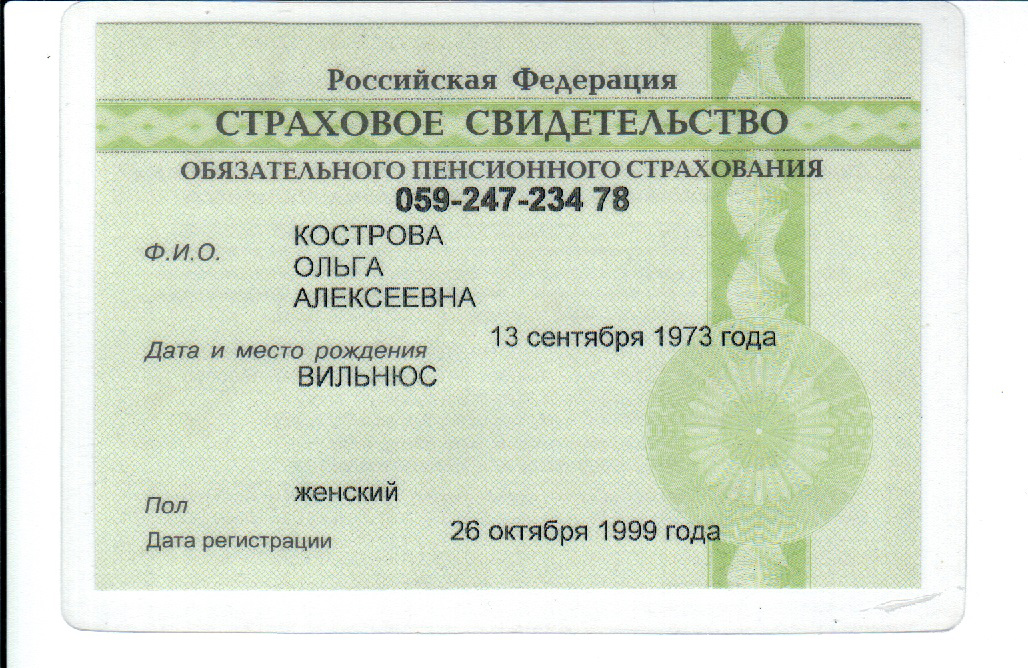

In [4]:
image

### Переведем координаты распознанных блоков в табличный вид

In [5]:
j = int(num_detections[0]) # Число выявленных блоков
table = pd.DataFrame()
tab_1 = []
tab_2 = []
tab_3 = []
tab_4 = []
for i in range(0,j):
    tab_1 = tab_1 + [boxes.T[1][i][0]]
    tab_2 = tab_2 + [boxes.T[3][i][0]]
    tab_3 = tab_3 + [boxes.T[0][i][0]]
    tab_4 = tab_4 + [boxes.T[2][i][0]]

table['y min'] = tab_3
table['x min'] = tab_1
table['y max'] = tab_4
table['x max'] = tab_2

table

,y min,x min,y max,x max
0,0.272130,0.377345,0.326277,0.619548
1,0.769379,0.437595,0.824952,0.704805
2,0.423419,0.282172,0.470349,0.469960
3,0.473984,0.476353,0.524629,0.760777
4,0.535796,0.288293,0.588556,0.427009
5,0.371509,0.281294,0.423047,0.380808
6,0.331167,0.286643,0.377391,0.436922
7,0.717610,0.278987,0.761953,0.394800


### Отсортируем таблицу по максимальному значению y

In [6]:
table = table.sort_values('y max')

table

,y min,x min,y max,x max
0,0.272130,0.377345,0.326277,0.619548
6,0.331167,0.286643,0.377391,0.436922
5,0.371509,0.281294,0.423047,0.380808
2,0.423419,0.282172,0.470349,0.469960
3,0.473984,0.476353,0.524629,0.760777
4,0.535796,0.288293,0.588556,0.427009
7,0.717610,0.278987,0.761953,0.394800
1,0.769379,0.437595,0.824952,0.704805


### Переведем относительные координаты в координатные пиксели 

In [7]:
table = table * to_pixel

table

,y min,x min,y max,x max
0,181.783008,387.910901,217.953107,636.895184
6,221.219564,294.668911,252.097374,449.155463
5,248.167923,289.170281,282.595400,391.470344
2,282.844030,290.072902,314.193161,483.119221
3,316.621533,489.690567,350.452369,782.078630
4,357.911958,296.364810,393.155203,438.964840
7,479.363401,286.798197,508.984442,405.854898
1,513.945504,449.847272,551.067821,724.539618


### Произведем нарезку изображения на интересующие текстовые блоки

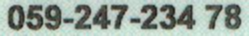

In [8]:
images_new = []
for i in range(0,j):
    img = image.crop( (table['x min'].iloc[i],table['y min'].iloc[i],table['x max'].iloc[i],table['y max'].iloc[i]) ) #дата
    img.save('cropp_'+str(i)+'.jpg')
    img = cv2.imread('cropp_'+str(i)+'.jpg')
    img = Image.fromarray(cv2.GaussianBlur(img,(3,3),0))
    images_new = images_new + [img]
    
images_new[0] 

### Применяем модуль tesserocr для OCR каждого изображения текстового блока в отдельности

In [9]:
text = []
for img in images_new:
    tex = tesserocr.image_to_text(img, lang='rus')
    tex = tex.replace(',', '.').replace("\n", '').replace("’", '').replace("'", '').replace('"', '').replace("?", '').replace("‘", '')
    text.append(tex) 
text

['059-247-234 78',
 'КОСТРОВА',
 'ОЛЬГА',
 'АЛЕКСЕЕВНА',
 '13 сентября 1973М',
 'вилЬнюс',
 'женский',
 '26 октября 1999 года']

### Структурируем информацию в словаре

In [10]:
data = {
    "number": text[0],
    "surname": text[1],
    "name": text[2],
    "patronymic": text[3],
    "birthday": text[4],
    "birthplace": text[5],
    "gender": text[6],   
    "registration": text[7]   
}

data

{'birthday': '13 сентября 1973М',
 'birthplace': 'вилЬнюс',
 'gender': 'женский',
 'name': 'ОЛЬГА',
 'number': '059-247-234 78',
 'patronymic': 'АЛЕКСЕЕВНА',
 'registration': '26 октября 1999 года',
 'surname': 'КОСТРОВА'}

### Производим запись в JSON файл

In [11]:
with open("data_file.json", "w") as write_file:
    json.dump(data, write_file)

    #                                                   successfully!